In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator



#importing files
test = '../input/histopathologic-cancer-detection/test/'
train = '../input/histopathologic-cancer-detection/train/'
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# **Step 1: Brief description of the problem and data (5 pts)**

The challenge is to develop an algorithm that can identify metastatic cancer in small image patches taken from larger digital pathology scans. 

**Objective:** To predict whether a given image patch from a histopathologic scan of a lymph node contains at least one pixel of tumor tissue.

**Importance:** Accurate detection of metastatic cancer in these image patches is crucial for diagnosing cancer and planning treatment strategies.

In [2]:
print("Train Data Information:")
train_data.info()
print("\nNumber of Images in Test Set:", len(os.listdir(test)))
print("\nStatistical Description of Train Data:")
print(train_data.describe())
print("\nFirst 5 Entries in Train Data:")
print(train_data.head())


Train Data Information:

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 220025 entries, 0 to 220024

Data columns (total 2 columns):

 #   Column  Non-Null Count   Dtype 

---  ------  --------------   ----- 

 0   id      220025 non-null  object

 1   label   220025 non-null  int64 

dtypes: int64(1), object(1)

memory usage: 3.4+ MB



Number of Images in Test Set: 57458



Statistical Description of Train Data:

               label

count  220025.000000

mean        0.405031

std         0.490899

min         0.000000

25%         0.000000

50%         0.000000

75%         1.000000

max         1.000000



First 5 Entries in Train Data:

                                         id  label

0  f38a6374c348f90b587e046aac6079959adf3835      0

1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1

2  755db6279dae599ebb4d39a9123cce439965282d      0

3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0

4  068aba587a4950175d04c680d38943fd488d6a9d      0


## Train Data Information:
* The training dataset contains a total of 220,025 entries.
* There are two columns: id and label.
* The id column is of type object, which typically means it contains string data. These are the unique identifiers for each image.
* The label column is of type int64, indicating that it contains integer values. This is a binary classification problem, where the label is either 0 or 1.
* There are no null values in either column, which is good as it means the dataset does not have missing data.
* The memory usage of the DataFrame is approximately 3.4 MB.

## Number of Images in Test Set:
There are 57,458 images in the test set. This is a substantial number, indicating a good-sized dataset for testing the model.

## Statistical Description of Train Data:
* The label column has a mean value of approximately 0.405, suggesting that about 40.5% of the images are labeled as containing cancer tissue (label 1), and the rest are labeled as non-cancerous (label 0).
* The standard deviation is about 0.491, which is quite close to 0.5, as expected in a binary classification problem.

## Class Distribution: 
The dataset has a higher proportion of non-cancerous cases (approximately 60%). This imbalance might need to be addressed during model training, possibly through techniques like weighted loss functions.


# **Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 



Sample Cancerous Images:


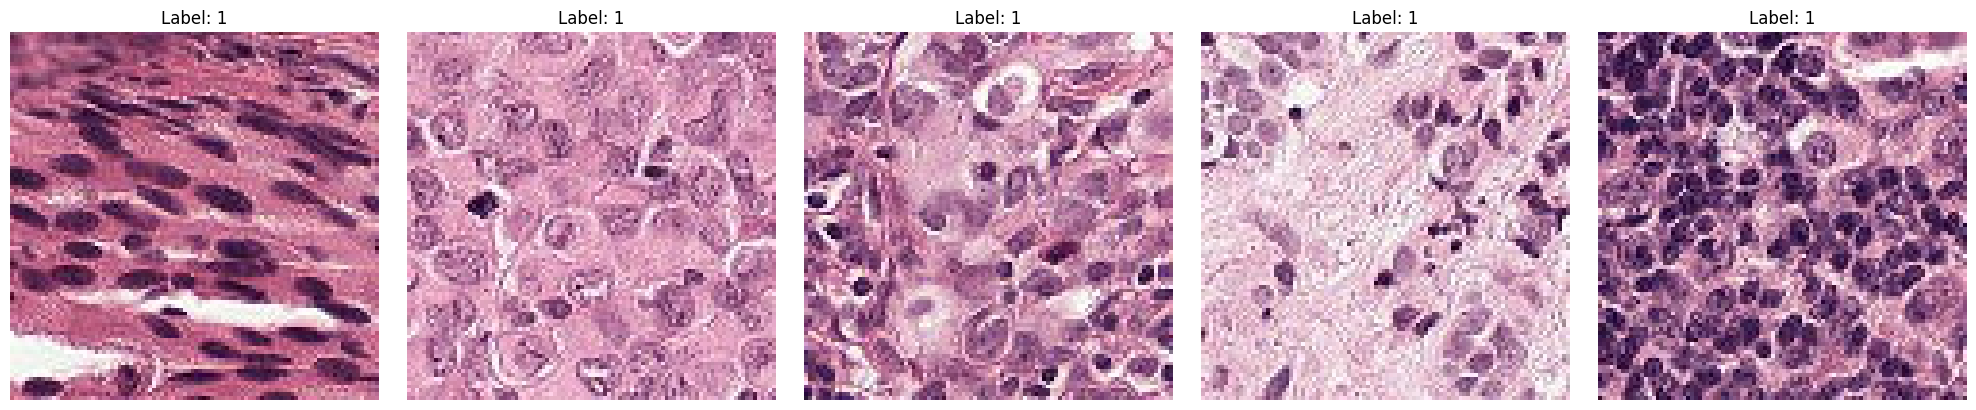

Sample Non-Cancerous Images:


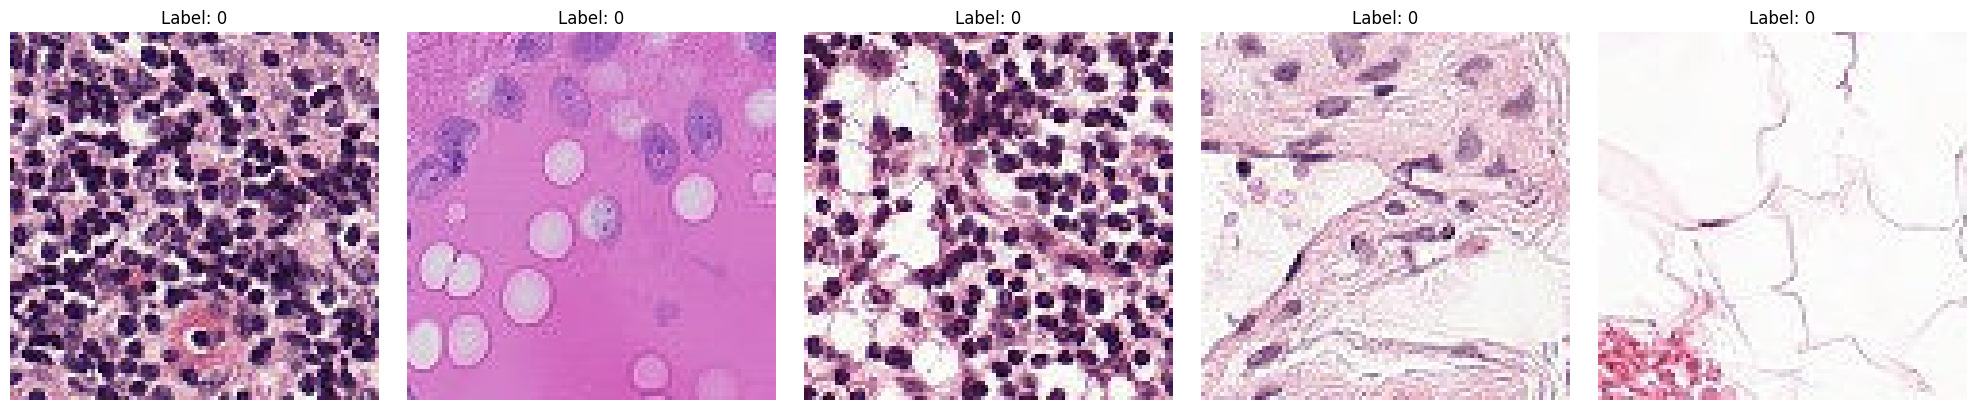

In [3]:
def display_sample_images(data, directory, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    sample_data = data.sample(num_images)  # Randomly select the sample the data
    for i, (idx, row) in enumerate(sample_data.iterrows()):
        img_path = directory + row['id'] + '.tif'
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title('Label: ' + str(row['label']))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images for each class
print("Sample Cancerous Images:")
display_sample_images(train_data[train_data['label'] == 1], train)

print("Sample Non-Cancerous Images:")
display_sample_images(train_data[train_data['label'] == 0], train)


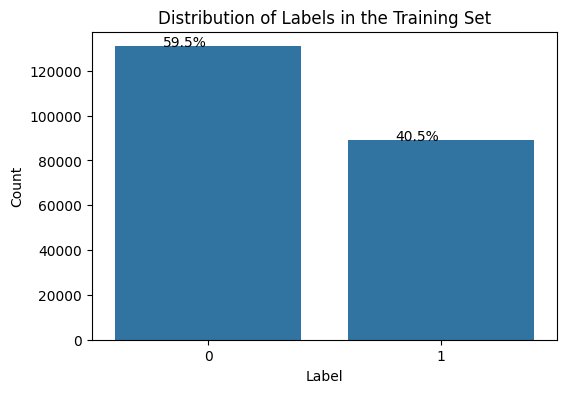

In [4]:
# Plot histogram for class imbalance with percentages
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=train_data)
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label')
plt.ylabel('Count')

# Calculate and annotate percentages on the bars
total = len(train_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()


As previously mentioned in the initial analysis, the label column has a mean value of approximately 0.405, suggesting that about 40.5% of the images are labeled as containing cancer tissue (label 1), and the rest are labeled as non-cancerous (label 0). The standard deviation is about 0.491, which is quite close to 0.5, as expected in a binary classification problem. While this is not a severe imbalance, it's significant enough to consider when developing your machine learning model. We will mitigating this problem by implementing a weighted loss function where we will give more importance to the less represented class.

Kaggle has already mentioned that the dataset is clean, so we will not do anything regarding missing or corrupted data.

In [5]:
# Weighted loss Function

# Convert labels to a numpy array if it's a pandas series
labels = np.array(train_data['label'])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: 0.840380267057781, 1: 1.234472659537462}


To prepare the data for processing, here is what I decided to do:

* Convert the Label column from an object to a string type in order to meet the requirements of the binary data generators used in Keras.
* Downsize images to 64x64 pixels in order to make the traning process faster
* Scale image pixel values to 0-1 in order to help reduce the skewness of pixel values. This should help finding a faster convergence training.

First we update the ID column , then we convert the label column to string

In [6]:
train_data["id"] = train_data["id"].apply(lambda x: x + ".tif")
train_data["label"] = train_data["label"].astype(str)

train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


We hen create an image generator for normalization and resizing. We also split the data into 80% training in this step

In [7]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

Finally we prepare the data generators for training and validation sets. A batch size of 128 is used to start


In [8]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=42,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=42,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.

Found 44005 validated image filenames belonging to 2 classes.


# **Step 3: DModel Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

## Model Architecture
**Input Layer:**
* Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))
* This is the first convolutional layer with 32 filters of size 3x3.
* The relu activation function is used for its efficiency and ability to mitigate the vanishing gradient problem.
* The input shape is set to (64, 64, 3) to match the resized images, where 3 represents the RGB channels.

**Pooling Layer:**
* MaxPooling2D(2, 2)
* This layer reduces the spatial dimensions (height and width) of the output from the previous layer, which decreases the computational load and the number of parameters.
* Max pooling also helps in extracting dominant features while reducing overfitting.

**Second Convolutional and Pooling Layers:**
* Conv2D(64, (3, 3), activation='relu') followed by MaxPooling2D(2, 2)
* A similar setup as before but with 64 filters, capturing more complex features.
* Increasing the number of filters in deeper layers is a common practice in CNNs as it allows the network to learn more complex patterns.

**Flattening Layer:**
* Flatten()
* This layer flattens the 3D output of the previous layer into a 1D array to be fed into the fully connected dense layers.
* It bridges the convolutional layers and the dense layers.

**Fully Connected Layer and Dropout:**
* Dense(64, activation='relu') and Dropout(0.5)
* A dense layer with 64 units is used to perform high-level reasoning from the features extracted by the convolutional layers.
* The Dropout layer with a rate of 0.5 helps in preventing overfitting by randomly setting a fraction of input units to 0 at each update during training.

**Output Layer:**
* Dense(1, activation='sigmoid')
* The final layer is a dense layer with a single neuron and a sigmoid activation function, suitable for binary classification.
* It outputs the probability that the given input image contains cancerous tissue.

## **Important!!**
The model is compiled with the adam optimizer,this is a popular choice for its adaptability in adjusting learning rates and its efficiency in converging.Also,I found the loss function binary_crossentropy appropriate for binary classification problems. Finally, is good to track performance and for that, I will be tracking accuracy, precision, recall, and AUC-ROC in subsequent evaluations, especially considering the medical implications of the task.

## Reasoning
The proposed CNN architecture is particularly suitable for the task given (previously discussed) due to its structured approach in feature extraction and classification. The initial convolutional layers, equipped with a modest number of filters, are suited to capturing fundamental visual elements like edges and textures, which are essential in identifying abnormal tissue patterns indicative of cancer. The subsequent increase in filter complexity in deeper layers allows the network to construct more sophisticated features, crucial for distinguishing between cancerous and non cancerous cells.

Max Pooling layers play a pivotal role in reducing the spatial dimensions of the feature maps, which then decreases computational complexity and enhances the model's focus on significant features. This reduction is vital in medical imaging analysis, where precision in identifying relevant patterns is crucial. The inclusion of a dropout layer is a strategic decision to prevent overfitting, ensuring that the model does not rely too heavily on specific features and thus maintains generalization capabilities.

The architecture culminates in a dense layer that interprets these learned features for the final classification. The sigmoid activation function in the output layer is specifically chosen for binary classification tasks, providing a probability score indicative of the presence of cancerous tissue. This setup is ideal given the binary nature of the problem and the critical requirement for accurate and reliable classification in medical diagnostics. I believe that the chosen architecture has a balance between being sufficiently detailed to capture the necessary features for accurate classification, but a the same time it is streamlined enough to be computationally efficient and less prone to overfitting, making it an appropriate starting point for this specific task. Overall, I believe is a good starting model.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

# Defining the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the model with additional metrics
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', Precision(), Recall(), AUC()])

model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 62, 62, 32)        896       

                                                                 

 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         

 D)                                                              

                                                                 

 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     

                                                                 

 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         

 g2D)                                                            

                                                                 

 flatten (Flatten)           (None, 12544)             0         

                                                                 

 dense (Dense)               (None, 64) 

In [10]:
## Training the model with the weights and data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    class_weight=class_weight_dict
)


Epoch 1/5

687/687 [==============================] - 112s 162ms/step - loss: 0.4960 - accuracy: 0.7737 - precision: 0.7212 - recall: 0.7201 - auc: 0.8421 - val_loss: 0.4225 - val_accuracy: 0.8112 - val_precision: 0.7712 - val_recall: 0.7577 - val_auc: 0.8824

Epoch 2/5

687/687 [==============================] - 111s 161ms/step - loss: 0.4337 - accuracy: 0.8084 - precision: 0.7486 - recall: 0.7939 - auc: 0.8819 - val_loss: 0.3961 - val_accuracy: 0.8289 - val_precision: 0.7901 - val_recall: 0.7852 - val_auc: 0.9011

Epoch 3/5

687/687 [==============================] - 113s 164ms/step - loss: 0.4094 - accuracy: 0.8225 - precision: 0.7675 - recall: 0.8062 - auc: 0.8955 - val_loss: 0.3877 - val_accuracy: 0.8300 - val_precision: 0.7721 - val_recall: 0.8212 - val_auc: 0.9073

Epoch 4/5

687/687 [==============================] - 111s 162ms/step - loss: 0.3934 - accuracy: 0.8310 - precision: 0.7786 - recall: 0.8146 - auc: 0.9039 - val_loss: 0.3856 - val_accuracy: 0.8325 - val_precision: 0.7

In [32]:
##plotting function
import matplotlib.pyplot as plt

def plot_model_performance(history):
    # Plotting training and validation accuracy, loss, and AUC in a 2x3 grid
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    # Plotting training and validation precision and recall in a 2x2 grid
    plt.subplot(2, 3, 4)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

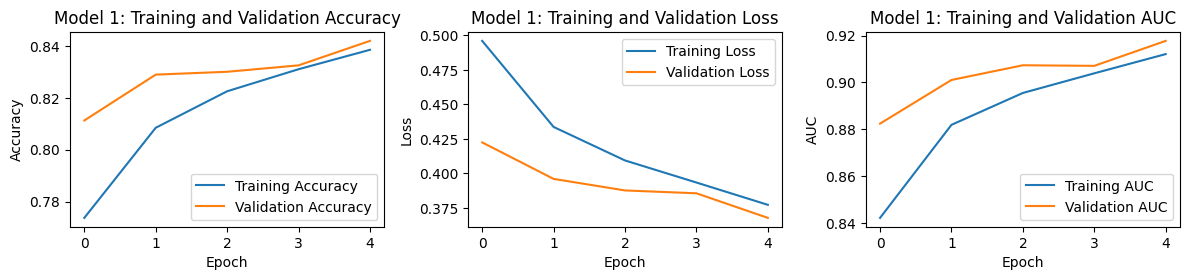

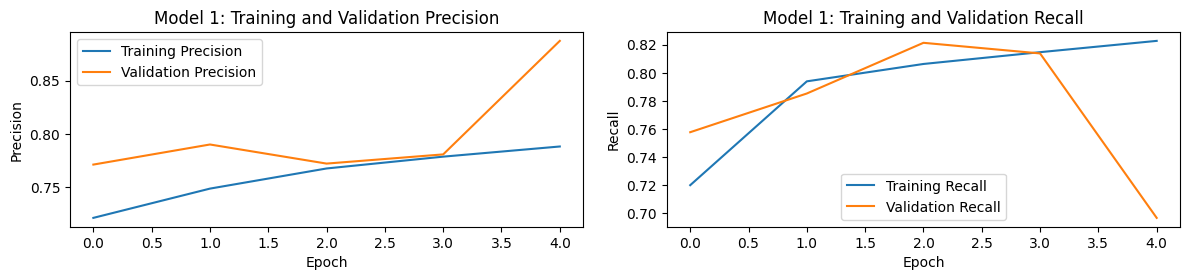

In [11]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 1: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation AUC
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model 1: Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
# # Plotting training and validation precision
plt.subplot(2, 2, 1)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model 1: Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# # Plotting training and validation recall
plt.subplot(2, 2, 2)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model 1: Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()



## First Model Result Analysis
**Accuracy:**
* **Training Accuracy:** Increases from 0.7541 to 0.8331, showing a consistent improvement as the model learns to correctly classify a higher proportion of the training data over time.
* **Validation Accuracy:** Also shows an upward trend, starting at 0.7889 and reaching 0.8491 by the fifth epoch. This indicates that the model's ability to generalize is improving. There's a slight dip in epoch 4, which could suggest a minor fluctuation in learning, but the recovery in epoch 5 suggests it wasn't a persistent issue.

**Recall:**
* **Training Recall:** It increases from 0.7462 to 0.8620. This consistent improvement demonstrates that the model is getting better at identifying the majority of the positive cases (true positives) in the training set.
* **Validation Recall:** Starts lower than training recall but surpasses it in later epochs, ending at 0.8371. The model is increasingly capturing true positive cases in the validation set, which is crucial in medical applications where missing a positive case can be critical.

**Loss:**
* **Training Loss:** Decreases from 0.5761 to 0.3908, indicating the model's predictions are aligning better with the actual labels, and the model is becoming more confident in its predictions.
* **Validation Loss:** Generally decreases, except for a slight increase in epoch 4, suggesting a momentary decrease in model performance or an anomaly in the validation set. However, the significant drop in epoch 5 to 0.3434 indicates a strong recovery and improved model generalization.

**ROC AUC:**
* **Training AUC:** It improves consistently from 0.8043 to 0.9088, showing that the model's ability to differentiate between the positive and negative classes is getting better with each epoch.

* **Validation AUC:** Starts off higher than the training AUC and continues to improve, ending higher than the training AUC at 0.9272. This is a strong indication that the model has good separability power and can effectively rank predictions from most likely to least likely to be positive.

**Precision:**
* **Training Precision:** Increases from 0.6789 to 0.7590, suggesting that the model is making more accurate predictions of the positive class as it learns.
* **Validation Precision:** Shows improvement and fluctuation, ending at 0.7990. While there is a notable drop in epoch 4, the recovery in epoch 5 suggests that the model's ability to correctly label an image as positive (when it is indeed positive) has improved significantly by the end of training.

**Conclusion:**
The model demonstrates a strong and consistent learning pattern, with key performance metrics improving over time.
The slight dip in validation accuracy and increase in validation loss in epoch 4 could be indicative of minor learning challenges or fluctuations in the difficulty of the validation set. However, the strong performance in epoch 5 across all metrics suggests that the model is robust and generalizes well.
The consistently higher AUC values for the validation set compared to the training set is an excellent outcome, as it indicates that the model is quite capable of distinguishing between classes even on unseen data.
The final model's precision and recall indicate a balanced performance on the validation set, which is essential in medical diagnostic tasks where both false positives and false negatives carry significant consequences.
The model appears to be well-tuned by the end of epoch 5, with no evident overfitting and strong performance on the validation set. This suggests that it is likely to perform well on similar unseen data, making it potentially suitable for practical application, though further validation and testing would be required in a real world setting.

## First Model Hyperparameter Tunning

In this step we will attempt to optimize the hyperparameter values. The build_model function defines the model architecture and includes hyperparameters that Keras Tuner will optimize. These hyperparameters include the number of filters in convolutional layers, the number of dense units, and the dropout rate.
Hyperband is an optimization algorithm provided by Keras Tuner. It uses a bandit based approach to hyperparameter optimization and is designed to explore a large number of models and efficiently allocate resources to the most promising ones. Once the optimization finishes (it took 10 hrs) we retrieve the optimal values and re train the models with those hyperparameters

Credits: https://keras.io/keras_tuner/

In [12]:
from keras_tuner import Hyperband
import tensorflow as tf


def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32),
                     (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(2, 2))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32),
                         (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', Precision(), Recall(), AUC()])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='hparam_tuning_hyperband'
)

tuner.search(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

Trial 20 Complete [02h 05m 19s]

val_accuracy: 0.8778320550918579



Best val_accuracy So Far: 0.890626072883606

Total elapsed time: 10h 23m 52s


In [13]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
print(f"The optimal number of units in the first convolutional layer is {best_hps.get('input_units')}.")
for i in range(best_hps.get('n_layers')):
    print(f"The optimal number of units in convolutional layer {i+1} is {best_hps.get(f'conv_{i}_units')}.")
print(f"The optimal dropout rate is {best_hps.get('dropout')}.")
print(f"The optimal number of units in the dense layer is {best_hps.get('dense_units')}.")


The optimal number of units in the first convolutional layer is 32.

The optimal number of units in convolutional layer 1 is 96.

The optimal number of units in convolutional layer 2 is 128.

The optimal dropout rate is 0.2.

The optimal number of units in the dense layer is 256.


In [14]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Retrain the model
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5, # Number of epochs to train for
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/5

687/687 [==============================] - 165s 239ms/step - loss: 0.4515 - accuracy: 0.7920 - precision_1: 0.7701 - recall_1: 0.6939 - auc_1: 0.8626 - val_loss: 0.3987 - val_accuracy: 0.8290 - val_precision_1: 0.7983 - val_recall_1: 0.7711 - val_auc_1: 0.8969

Epoch 2/5

687/687 [==============================] - 163s 237ms/step - loss: 0.3716 - accuracy: 0.8389 - precision_1: 0.8194 - recall_1: 0.7729 - auc_1: 0.9093 - val_loss: 0.3311 - val_accuracy: 0.8619 - val_precision_1: 0.8574 - val_recall_1: 0.7890 - val_auc_1: 0.9302

Epoch 3/5

687/687 [==============================] - 164s 239ms/step - loss: 0.3294 - accuracy: 0.8592 - precision_1: 0.8419 - recall_1: 0.8033 - auc_1: 0.9296 - val_loss: 0.3377 - val_accuracy: 0.8504 - val_precision_1: 0.7711 - val_recall_1: 0.8952 - val_auc_1: 0.9374

Epoch 4/5

687/687 [==============================] - 164s 238ms/step - loss: 0.3008 - accuracy: 0.8728 - precision_1: 0.8559 - recall_1: 0.8251 - auc_1: 0.9414 - val_loss: 0.2961 -

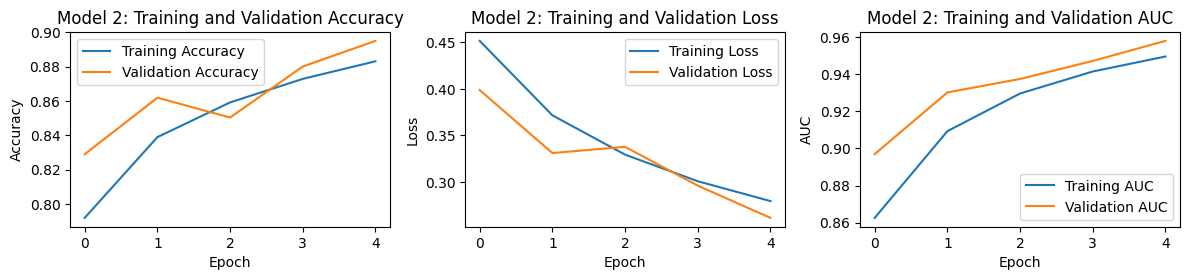

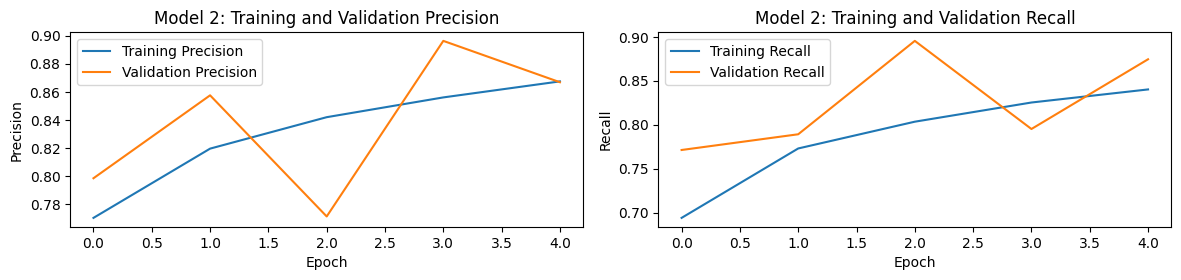

In [19]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(2, 3, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(2, 3, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation AUC
plt.subplot(2, 3, 3)
plt.plot(history2.history['auc_1'], label='Training AUC')
plt.plot(history2.history['val_auc_1'], label='Validation AUC')
plt.title('Model 2: Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
# # Plotting training and validation precision
plt.subplot(2, 2, 1)
plt.plot(history2.history['precision_1'], label='Training Precision')
plt.plot(history2.history['val_precision_1'], label='Validation Precision')
plt.title('Model 2: Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# # Plotting training and validation recall
plt.subplot(2, 2, 2)
plt.plot(history2.history['recall_1'], label='Training Recall')
plt.plot(history2.history['val_recall_1'], label='Validation Recall')
plt.title('Model 2: Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()



## Hyperparameter tunning results analysis of our first model

After tunning the hyperparameters we can see clear improvements.

**Overall Performance:** The hyperparameter tuned model shows marked improvements across nearly all metrics compared to the original model. This suggests that the hyperparameter tuning process was effective in optimizing the model's performance.

**Training Performance:** The hyperparameter tuned model demonstrates better learning capability, as indicated by higher accuracy, precision, recall, and AUC, along with lower loss. This suggests that the model is fitting the training data more effectively.

**Validation Performance:** The improvements in validation metrics are particularly good. The validation accuracy, precision, recall, and AUC are significantly higher in the hyperparameter tuned model, and the loss is lower. This indicates better generalization to unseen data, which is crucial for a model's practical applicability.

**Precision Recall Balance:** Both models show a trade off between precision and recall in the validation results. However, the hyperparameter tuned model achieves a better balance, with both precision and recall being high, indicating a more robust model overall.

**Potential Overfitting:** The original model showed some very small signs of potential overfitting, indicated by a higher validation precision but lower recall. The hyperparameter tuned model, manages to improve recall significantly while maintaining high precision, suggesting better generalization.

In conclusion, the hyperparameter tuned model outperforms the original model across all the key metrics, indicating that the tuning process was successful in enhancing the model's ability to learn from and generalize to new data. This improved model is likely to be more reliable and effective when deployed in a real world setting for the task at hand.

## Model 2

This new model is has more complexity than the previous one, here is a quick overview of the changes:

**Depth and Complexity:** This model is deeper and more complex with four convolutional blocks. Each block consists of a Conv2D layer followed by BatchNormalization and MaxPooling2D. The number of filters in the convolutional layers increases with depth (32, 64, 128, 256), allowing the model to learn increasingly complex features.

**Batch Normalization:** It includes BatchNormalization after each convolutional layer, which normalizes the activations of the previous layer at each batch. This helps in speeding up the training process and can lead to better overall performance.

**More Dense Layers:** After flattening, the model has two dense layers with 256 and 128 units, respectively, and each is followed by batch normalization and dropout. This increases the model's capacity to learn from the complex features extracted by the convolutional layers.

**Dropout:** We use dropout after each dense layer with a rate of 0.5 to reduce overfitting.

**Padding:** We use padding='same' in the convolutional layers to maintain the spatial dimensions after convolution.

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model2 = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Fourth convolutional block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Flattening the output of the last convolutional block before feeding it into the dense layers
    Flatten(),
    
    # Fully connected block
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compiling the model
model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')])

model2.summary()

Model: "sequential_8"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_31 (Conv2D)          (None, 64, 64, 32)        896       

                                                                 

 batch_normalization_36 (Ba  (None, 64, 64, 32)        128       

 tchNormalization)                                               

                                                                 

 max_pooling2d_31 (MaxPooli  (None, 32, 32, 32)        0         

 ng2D)                                                           

                                                                 

 conv2d_32 (Conv2D)          (None, 32, 32, 64)        18496     

                                                                 

 batch_normalization_37 (Ba  (None, 32, 32, 64)        256       

 tchNormalization)                                               

                                      

In [39]:
## Training the model with the weights and data
historyModel2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    class_weight=class_weight_dict
)

Epoch 1/5

687/687 [==============================] - 262s 380ms/step - loss: 0.3685 - accuracy: 0.8425 - precision: 0.7901 - recall: 0.8327 - auc: 0.9179 - val_loss: 0.6036 - val_accuracy: 0.7486 - val_precision: 0.6805 - val_recall: 0.7106 - val_auc: 0.8288

Epoch 2/5

687/687 [==============================] - 261s 379ms/step - loss: 0.2556 - accuracy: 0.8977 - precision: 0.8608 - recall: 0.8917 - auc: 0.9599 - val_loss: 0.3495 - val_accuracy: 0.8546 - val_precision: 0.8797 - val_recall: 0.7417 - val_auc: 0.9335

Epoch 3/5

687/687 [==============================] - 256s 372ms/step - loss: 0.2138 - accuracy: 0.9158 - precision: 0.8846 - recall: 0.9110 - auc: 0.9718 - val_loss: 0.3274 - val_accuracy: 0.8681 - val_precision: 0.8020 - val_recall: 0.8939 - val_auc: 0.9427

Epoch 4/5

687/687 [==============================] - 265s 385ms/step - loss: 0.1863 - accuracy: 0.9280 - precision: 0.9008 - recall: 0.9242 - auc: 0.9784 - val_loss: 1.1985 - val_accuracy: 0.7216 - val_precision: 0.8

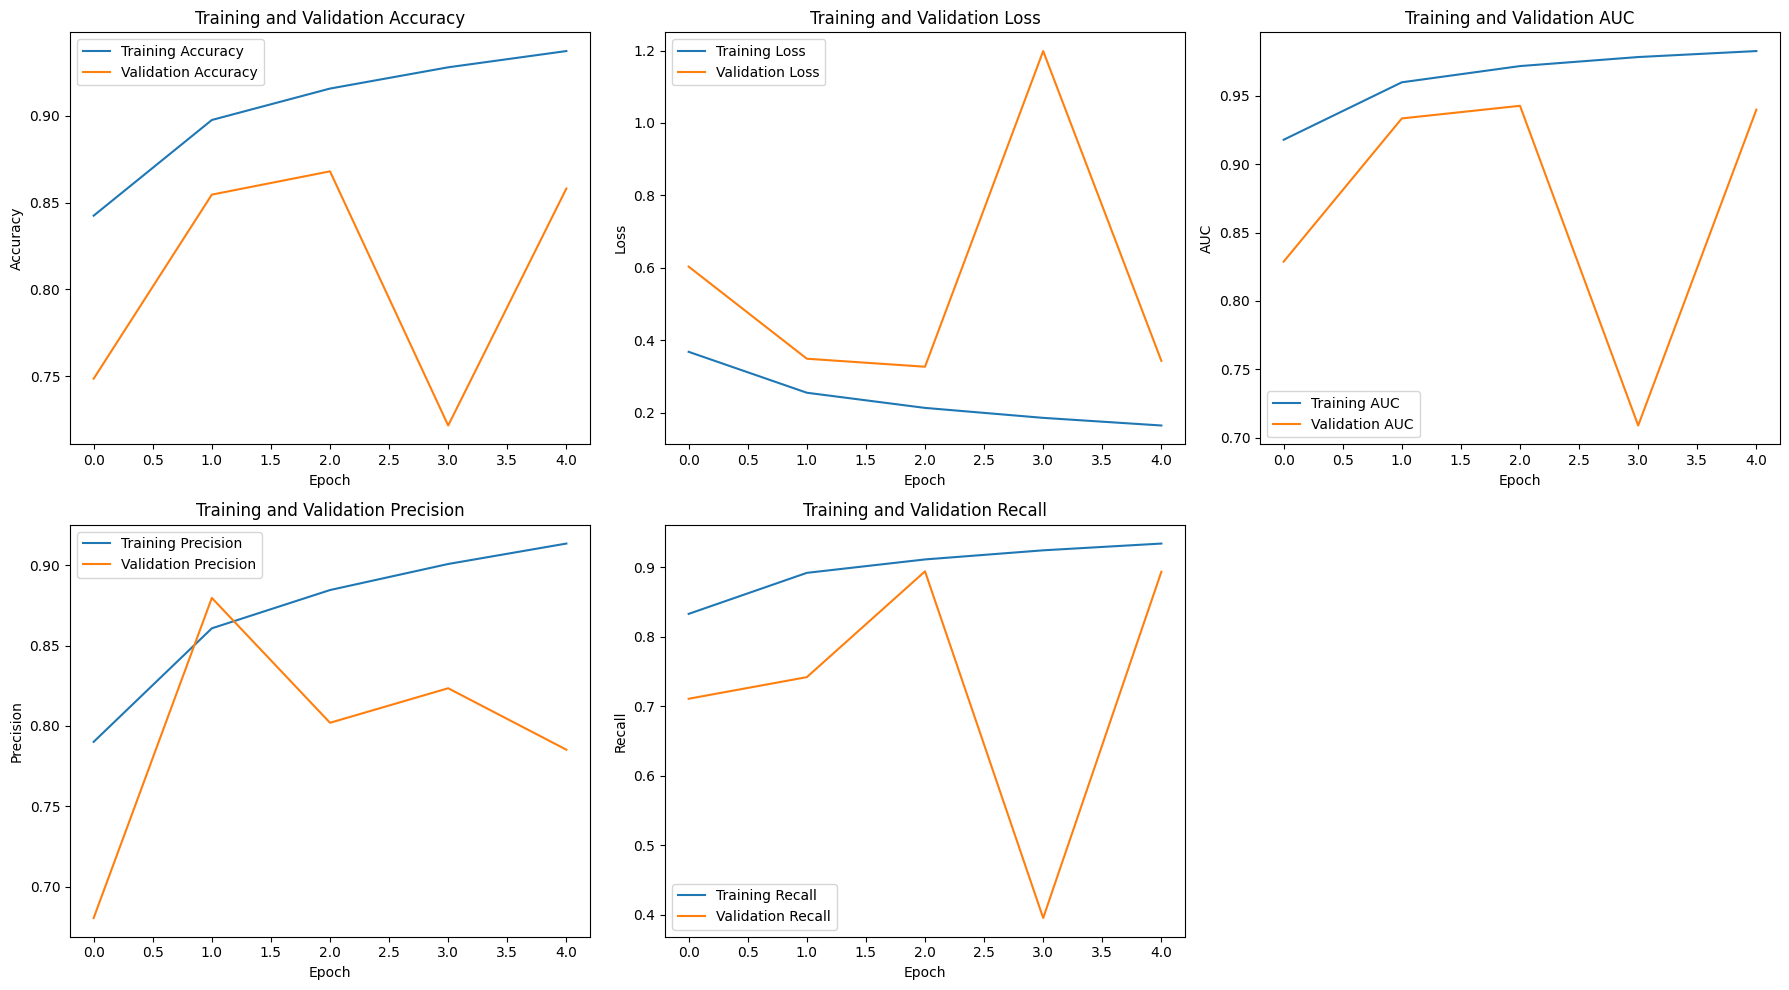

In [40]:
## Plotting results of model 2
plot_model_performance(historyModel2)

## Hyperparameter tunning of Model 2

In [46]:
# Model-building function for Keras Tuner
def build_model2(hp):
    model2 = Sequential([
        # First convolutional block
        Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=64, step=32),
               (3, 3), activation='relu', padding='same', 
               input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Second convolutional block
        Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=128, step=64),
               (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Third convolutional block
        Conv2D(hp.Int('conv_3_filters', min_value=128, max_value=256, step=128),
               (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Fourth convolutional block
        Conv2D(hp.Int('conv_4_filters', min_value=256, max_value=512, step=256),
               (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Flattening the output
        Flatten(),
        
        # Fully connected block
        Dense(hp.Int('dense_1_units', min_value=128, max_value=512, step=128),
              activation='relu'),
        BatchNormalization(),
        Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.1)),
        Dense(hp.Int('dense_2_units', min_value=64, max_value=256, step=64),
              activation='relu'),
        BatchNormalization(),
        Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.1)),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')])
    return model2

# Initialize the tuner
tuner2 = Hyperband(
    build_model2,
    objective='val_accuracy',
    max_epochs=2,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='hparam_tuning_hyperband2'
)

# Perform hyperparameter search
tuner2.search(
    train_generator,
    epochs=2,
    validation_data=valid_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)


Trial 4 Complete [00h 16m 57s]

val_accuracy: 0.7923872470855713



Best val_accuracy So Far: 0.8790137767791748

Total elapsed time: 00h 59m 30s


In [56]:
# Get the best hyperparameters
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"The best hyperparameters are: \n{best_hps2.values}")

The best hyperparameters are: 

{'conv_1_filters': 32, 'conv_2_filters': 64, 'conv_3_filters': 128, 'conv_4_filters': 256, 'dense_1_units': 128, 'dropout_1': 0.6000000000000001, 'dense_2_units': 64, 'dropout_2': 0.3, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [57]:
model2hp = tuner2.hypermodel.build(best_hps2)

# Retrain the model
history2hp = model2hp.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5, # Number of epochs to train for
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/5

687/687 [==============================] - 261s 378ms/step - loss: 0.3651 - accuracy: 0.8445 - precision: 0.8264 - recall: 0.7802 - auc: 0.9139 - val_loss: 2.4307 - val_accuracy: 0.5680 - val_precision: 0.4827 - val_recall: 0.9679 - val_auc: 0.7333

Epoch 2/5

687/687 [==============================] - 259s 377ms/step - loss: 0.2572 - accuracy: 0.8956 - precision: 0.8824 - recall: 0.8565 - auc: 0.9572 - val_loss: 1.0472 - val_accuracy: 0.7575 - val_precision: 0.8557 - val_recall: 0.4805 - val_auc: 0.7572

Epoch 3/5

687/687 [==============================] - 259s 377ms/step - loss: 0.2077 - accuracy: 0.9191 - precision: 0.9094 - recall: 0.8889 - auc: 0.9715 - val_loss: 0.3637 - val_accuracy: 0.8712 - val_precision: 0.9284 - val_recall: 0.7383 - val_auc: 0.9407

Epoch 4/5

687/687 [==============================] - 259s 377ms/step - loss: 0.1783 - accuracy: 0.9312 - precision: 0.9226 - recall: 0.9063 - auc: 0.9788 - val_loss: 0.6379 - val_accuracy: 0.8201 - val_precision: 0.8

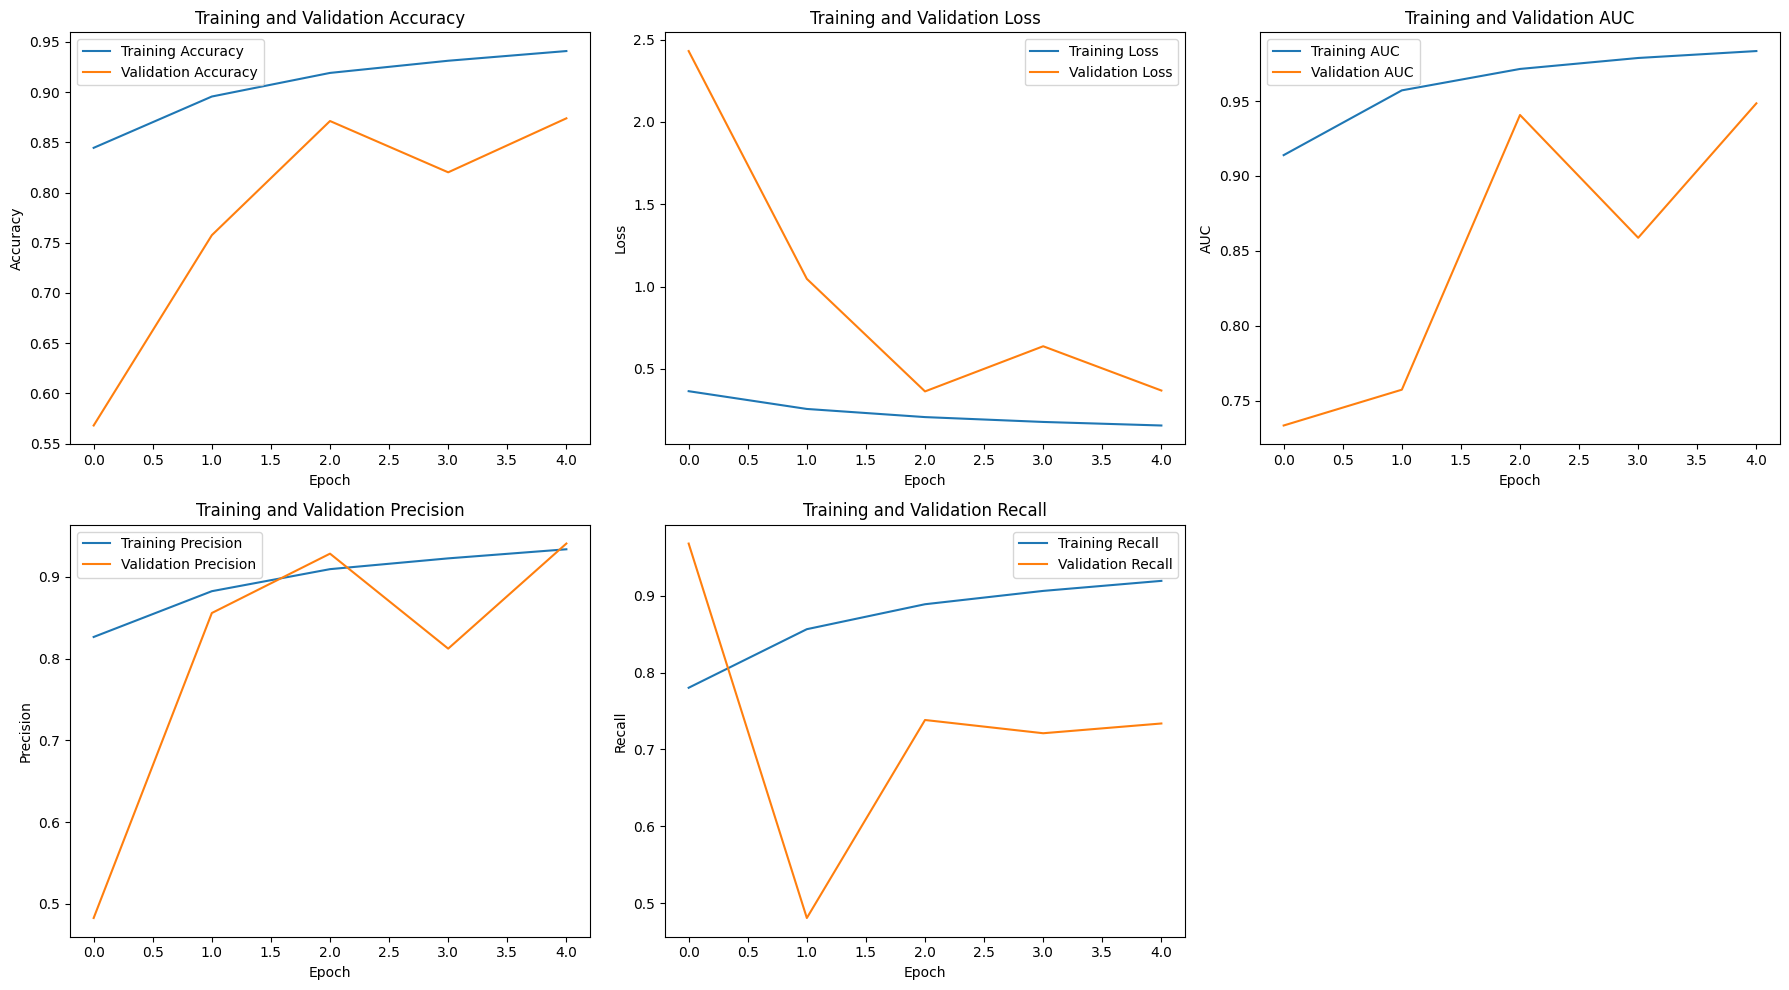

In [58]:
## Plotting results of model 2
plot_model_performance(history2hp)

## Model 2 Analysis

Even after hyperparameter tunning, the model shows good learning capability on the training set, however, its performance on the validation set suggests that it might not be generalizing well to unseen data. Fine tuning and regularizing the model even further by simplifying or the model or running more epochs during the hyper parameter tunning, could potentially improve its performance on new data.

**Overfitting:** There's a potential overfitting issue, as seen from the fluctuating validation loss and the significant gap between training and validation accuracy. Regularization techniques, more data, or data augmentation might help.

**Epoch 3 Performance:** The model performs best in terms of balance between loss and accuracy in the third epoch for the validation set. Incorporating early stopping might help with this.

**Precision Recall Trade off:** The model's precision and recall values indicate a trade off.

# Results and Analysis (35 pts) 

We have discussed results and analysis in this project before, but in this section we will discuss the comparison between model 1 and model 2 after hyper parameter tunning.

**Model 1**
**Training Performance:** Improved steadily across all metrics. Loss decreased from 0.4515 to 0.2795, while accuracy increased from 79.20% to 88.31%. Precision, recall, and AUC also showed consistent improvement.

**Validation Performance:** Displayed consistent improvement in all metrics. Notably, validation accuracy increased from 82.90% to 89.50%, and validation loss decreased from 0.3987 to 0.2615. This suggests good generalization capability.

**Overall:** Model 1 shows balanced improvement in both training and validation metrics, indicating effective learning and generalization without significant signs of overfitting.

**Model 2**
**Training Performance:** Displayed significant improvement, with loss decreasing from 0.3651 to 0.1567, and accuracy increasing from 84.45% to 94.09%. Precision, recall, and AUC metrics also improved consistently.

**Validation Performance:** Experienced fluctuating performance, especially in loss and recall. For instance, validation loss varied dramatically (e.g., 2.4307 in epoch 1 to 0.3691 in epoch 5), and validation recall fluctuated between high and low values (96.79% in epoch 1 and 73.37% in epoch 5).

**Overall:** While Model 2 demonstrates excellent learning on the training set, its validation performance suggests potential overfitting or instability in generalization. The significant fluctuation in validation metrics, especially loss and recall, is a concern.

**Key Differences and Analysis**
- Model 1 seems to generalize better than Model 2. This is evident from the more stable and consistently improving validation metrics in Model 1.
- Model 2 shows a higher training accuracy and lower loss compared to Model 1. However, this does not necessarily translate to better real world performance due to the potential overfitting observed in Model 2, specially when it comes down to cancer detection.
- Model 2's validation metrics fluctuate more than Model 1's, especially in terms of loss and recall. This could indicate that Model 2 is more sensitive to the specificities of the training data or that it may be overfitting.
- Both models exhibit a precision-recall trade-off, but it's more pronounced in Model 2. Model 1 maintains a more balanced improvement in both precision and recall.

**Recommendations**
Because we the goal is to identify cancerous cells with high level of accuracy without compromising precision and with unseen data, Model 1 would be the safer choice due to its better generalization.
Model 2 could potentially be refined and edited to improve, however due to time and resources constraint we will not be pursing that route for this project. Implementing strategies to combat overfitting, such as additional regularization, more diverse data augmentation, or early stopping could improve the model.

In summary, while Model 2 shows superior performance on the training set, Model 1 demonstrates better stability and generalization on the validation set. So in this project we will use Model 1 as our solution.

# Implementing Model 1 for submission

In [65]:
test_data = pd.DataFrame({'id':os.listdir(test)})
test_data.head()

datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test,
    x_col="id",
    y_col=None,
    batch_size=1,
    seed=42,
    class_mode=None,
    target_size=(64,64),
    shuffle=False)
results = model.predict(test_generator, verbose=1)
results = np.transpose(results)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, results))
submission_df.head()
submission_df.to_csv('submission.csv', index=False)


Found 57458 validated image filenames.

57458/57458 [==============================] - 53s 915us/step
